In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("Market basket").getOrCreate()

# Wrangling data

In [202]:
# Import raw data file and trim leading and trailing whitespaces
retail_df = spark.read.csv("data.csv", header=True, inferSchema=True)

In [203]:
# First glance at the data
retail_df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [204]:
# Register retail_df as a temporary view to use SQL syntax
retail_df.createOrReplaceTempView("retail_view")

In [205]:
# Columns description
description = spark.sql("""
    DESCRIBE retail_view
""")
description.show()

+-----------+---------+-------+
|   col_name|data_type|comment|
+-----------+---------+-------+
|  InvoiceNo|   string|   null|
|  StockCode|   string|   null|
|Description|   string|   null|
|   Quantity|      int|   null|
|InvoiceDate|   string|   null|
|  UnitPrice|   double|   null|
| CustomerID|      int|   null|
|    Country|   string|   null|
+-----------+---------+-------+



In [206]:
retail_df.describe().show()

+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|    InvoiceDate|         UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+------------------+---------------+------------------+------------------+-----------+
|  count|            541909|            541909|              540455|            541909|         541909|            541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0|  9.55224954743324|           null|4.6111136260897085|15287.690570239585|       null|
| stddev|13428.417280796779|16799.737628427658|                null|218.08115785023438|           null| 96.75985306117963|1713.6003033215982|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|        

Based on the provided table, we can draw the following conclusions:

* In the Quantity column, the minimum value of -80995 suggests the presence of negative quantities, which might indicate entry mistakes. The maximum value of 80995 represents a large quantity, potentially indicating bulk orders or high-demand items.

* The negative value of -11062.06, in the UnitPrice column, is unusual and might indicate errors or data entry mistakes. The maximum value of 38970.0 suggests the presence of high-priced items or possibly outliers that need further investigation.

* Missing Values: The "count" row indicates the number of non-null values for each column. The Description and CustomerID columns have fewer non-null values (Description = 540,455 and CustomerID = 406,829) compared to the total number of records (541,909), suggesting the presence of missing or incomplete descriptions for some items. The presence of "Unspecified" in The "Country" column suggests missing or incomplete data for some invoices. 


In [207]:
# CANCELLATIONS
# If the InvoiceNo starts with the letter 'C', it indicates a cancellation. The code below calculate 
# the total number of cancellations
cancellations = spark.sql("""
    SELECT COUNT(*) AS Total
    FROM retail_view
    WHERE InvoiceNo LIKE 'C%'
""")
cancellations.show()

# cancellations = retail_df.filter(retail_df.InvoiceNo.startswith('C')).agg({"*": "count"}).alias("Total")


+-----+
|Total|
+-----+
| 9288|
+-----+



In [208]:
# Remove cancellations from the analysis using SQL
Store_Retail = spark.sql("""
    SELECT *
    FROM retail_view
    WHERE NOT InvoiceNo LIKE 'C%'
""")

In [209]:
# NEGATIVE QUANTITIES
# Filter by non-positive Quantity and group by Description and UnitPrice, then count the occurrences using SQL
negative_quantities = spark.sql("""
    SELECT Description, UnitPrice, COUNT(*) AS count
    FROM retail_view
    WHERE Quantity <= 0
    GROUP BY Description, UnitPrice
""")

# Show the result ordered by count 
negative_quantities.orderBy(negative_quantities["count"].desc()).show()

+--------------------+---------+-----+
|         Description|UnitPrice|count|
+--------------------+---------+-----+
|                null|      0.0|  862|
|               check|      0.0|  120|
|REGENCY CAKESTAND...|    12.75|  104|
|REGENCY CAKESTAND...|    10.95|   77|
|JAM MAKING SET WI...|     4.25|   70|
|SET OF 3 CAKE TIN...|     4.95|   70|
|ROSES REGENCY TEA...|     2.95|   49|
|             damages|      0.0|   45|
|RECIPE BOX PANTRY...|     2.95|   43|
|STRAWBERRY CERAMI...|     1.25|   43|
|             damaged|      0.0|   42|
|                   ?|      0.0|   41|
|GREEN REGENCY TEA...|     2.95|   40|
|SET OF 3 REGENCY ...|     4.95|   34|
|ALARM CLOCK BAKEL...|     3.75|   33|
|PINK REGENCY TEAC...|     2.95|   33|
|RED RETROSPOT CAK...|    10.95|   33|
|SET OF TEA COFFEE...|     4.95|   33|
|LUNCH BAG RED RET...|     1.65|   32|
|SMALL GLASS HEART...|      2.1|   30|
+--------------------+---------+-----+
only showing top 20 rows



In [210]:
# Remove rows with non-positive Quantity using SQL
Store_Retail = spark.sql("""
    SELECT *
    FROM retail_view
    WHERE Quantity > 0
""")


#==========================================================================================================

One complexe task in this dataset is filter non-product related rows. Here you can leverage Large Language Models (LLMs) like to filter non-product descriptions in the Retail store dataset. LLMs have the capability to understand and generate natural language text, which makes them suitable for text classification tasks like identifying non-product descriptions. To filter non-product descriptions using an LLM, you can follow these general steps:

Prepare the data: Extract the description column from the Retail store dataset and convert it into a format suitable for LLM input. For example, you may need to preprocess the text by removing punctuation, converting to lowercase, and tokenizing the sentences.

Classification: Use the fine-tuned LLM to classify each description in the dataset as either a product or non-product. Pass the descriptions through the LLM and analyze the generated outputs or predictions to determine the class label for each description.

Filter the dataset: Filter the Retail store dataset based on the classification results to separate the product and non-product descriptions.

If you don't have the resources or expertise for fine-tuning an LLM, alternative methods like keyword matching or rule-based techniques might be more feasible for filtering non-product descriptions in the Retail store dataset. These methods involve searching for specific words or patterns that indicate non-product items or categories, as discussed earlier.

In [211]:
unique_descriptions = spark.sql("SELECT DISTINCT Description FROM retail_view")

In [212]:
# Display the unique values
unique_descriptions.count()

4224

In [215]:
# Saving unique_descriptions data for the analysis phase with LLM
unique_descriptions.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("unique_descriptions.csv")

In [ ]:
# DESCRIPTION
# Additional adjustment codes to remove
descrip = ["check", "check?", "?", "??", "damaged", "found", "adjustment", "Amazon", "AMAZON", "amazon adjust",
         "Amazon Adjustment", "amazon sales", "Found", "FOUND", "found box", "Found by jackie ", "Found in w/hse",
         "dotcom", "dotcom adjust", "allocate stock for dotcom orders ta", "FBA",
         "Dotcomgiftshop Gift Voucher £100.00", "on cargo order", "wrongly sold (22719) barcode",
         "wrongly marked 23343", "dotcomstock", "rcvd be air temp fix for dotcom sit", "Manual",
         "John Lewis", "had been put aside", "for online retail orders", "taig adjust", "amazon",
         "incorrectly credited C550456 see 47", "returned", "wrongly coded 20713", "came coded as 20713",
         "add stock to allocate online orders", "Adjust bad debt", "alan hodge cant mamage this section",
         "website fixed", "did  a credit  and did not tick ret", "michel oops", "incorrectly credited C550456 see 47",
         "mailout", "test", "Sale error", "Lighthouse Trading zero invc incorr", "SAMPLES", "Marked as 23343",
         "wrongly coded 23343", "Adjustment", "rcvd be air temp fix for dotcom sit", "Had been put aside."]

# Filtering out the unwanted entries
Store_Retail = Store_Retail.filter(~Store_Retail.Description.isin(descrip))


In [169]:
# Define non-product related codes
Non_P_StockCode =['AMAZONFEE', 'BANK CHARGES', 'C2', 'DCGSSBOY', 
                  'DCGSSGIRL', 'DOT', 'gift_0001_', 'PADS', 'POST']

# Summary of non-product stockcodes using SQL
non_product_stockcodes = spark.sql(f"""
    SELECT StockCode, Description, COUNT(*) AS count
    FROM retail_view
    WHERE StockCode REGEXP '{'|'.join(Non_P_StockCode)}'
    GROUP BY StockCode, Description
""").alias("count")

non_product_stockcodes.orderBy(non_product_stockcodes["count"].desc()).show()

+------------+--------------------+-----+
|   StockCode|         Description|count|
+------------+--------------------+-----+
|        POST|             POSTAGE| 1252|
|         DOT|      DOTCOM POSTAGE|  709|
|          C2|            CARRIAGE|  143|
|BANK CHARGES|        Bank Charges|   37|
|   AMAZONFEE|          AMAZON FEE|   34|
|   DCGSSGIRL|     GIRLS PARTY BAG|   13|
|    DCGSSBOY|      BOYS PARTY BAG|   11|
|gift_0001_20|Dotcomgiftshop Gi...|    9|
|gift_0001_10|Dotcomgiftshop Gi...|    8|
|gift_0001_30|Dotcomgiftshop Gi...|    7|
|        PADS|PADS TO MATCH ALL...|    4|
|        POST|                null|    4|
|gift_0001_50|Dotcomgiftshop Gi...|    4|
|gift_0001_40|Dotcomgiftshop Gi...|    3|
|         DOT|                null|    1|
|gift_0001_20|to push order thr...|    1|
|gift_0001_10|                null|    1|
|gift_0001_30|                null|    1|
|          C2|                null|    1|
+------------+--------------------+-----+



In [170]:
# Remove non-product stockcodes using SQL
# Register retail_df as a temporary view
Store_Retail.createOrReplaceTempView("retail_view")
Store_Retail = spark.sql(f"""
    SELECT *
    FROM retail_view
    WHERE NOT StockCode REGEXP '{'|'.join(Non_P_StockCode)}'
""")


#==========================================================================================================

In [175]:

# Check for NA values in Description
Store_Retail.filter(Store_Retail.Description.isNull()).count()

# Remove rows with NA values in Description
Store_Retail = Store_Retail.filter(Store_Retail.Description.isNotNull())


In [176]:
# Filtering by an order number which contains the same stock code more than once
Store_Retail = spark.sql("""
    SELECT InvoiceNo, StockCode, Quantity, UnitPrice, CustomerID
    FROM retail_view
    WHERE InvoiceNo = '557886' AND StockCode = '22436'
""")


In [177]:
# Removing duplicates
Store_Retail = spark.sql("""
    SELECT *
    FROM (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY InvoiceNo, Description ORDER BY InvoiceNo) as row_number
        FROM retail_view
    ) tmp
    WHERE row_number = 1
""").drop("row_number")


In [178]:
row_count = Store_Retail.count()
print("Total row count:", row_count)

Total row count: 520566


In [179]:
# CUSTOMER ID
# Check for NA values in CustomerID
Store_Retail.select("CustomerID").summary().show()

+-------+------------------+
|summary|        CustomerID|
+-------+------------------+
|  count|            387772|
|   mean|15282.001227525454|
| stddev|1713.8704314594274|
|    min|             12346|
|    25%|             13941|
|    50%|             15144|
|    75%|             16788|
|    max|             18287|
+-------+------------------+



In [180]:
from pyspark.sql.functions import count, countDistinct

# Count unique values of InvoiceNo and CustomerID
Store_Retail.select(countDistinct("InvoiceNo").alias("UniqueInvoiceNo"), countDistinct("CustomerID").alias("UniqueCustomerID")).show()


+---------------+----------------+
|UniqueInvoiceNo|UniqueCustomerID|
+---------------+----------------+
|          20728|            4339|
+---------------+----------------+



In [181]:
# FINAL TOUCHES
# Perform final transformations
from pyspark.sql.functions import col, to_date, to_timestamp

Store_Retail = Store_Retail.withColumn("Description", col("Description").cast("string")) \
    .withColumn("Country", col("Country").cast("string")) \
    .withColumn("InvoiceNo", col("InvoiceNo").cast("double")) \
    .withColumn("Date", to_date("InvoiceDate")) \
    .withColumn("Time", to_timestamp("InvoiceDate", "HH:mm:ss").cast("string"))

Store_Retail.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----+----+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|Date|Time|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+----+----+
| 536370.0|    22661|CHARLOTTE BAG DOL...|      20|12/1/2010 8:45|     0.85|     12583|        France|null|null|
| 536370.0|    22659|LUNCH BOX I LOVE ...|      24|12/1/2010 8:45|     1.95|     12583|        France|null|null|
| 536373.0|    21730|GLASS STAR FROSTE...|       6|12/1/2010 9:02|     4.25|     17850|United Kingdom|null|null|
| 536373.0|   82494L|WOODEN FRAME ANTI...|       6|12/1/2010 9:02|     2.55|     17850|United Kingdom|null|null|
| 536375.0|    21871| SAVE THE PLANET MUG|       6|12/1/2010 9:32|     1.06|     17850|United Kingdom|null|null|
+---------+---------+--------------------+--------+--------------+---------+----------+---------

In [182]:
# Saving cleansed data for the analysis phase
Store_Retail.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("CleanRetailData1.csv")

# Exploratory data analysis

In [183]:
from pyspark.sql.functions import hour, weekofyear
import matplotlib.pyplot as plt
import seaborn as sns

df = Store_Retail
# What items do people buy more often?
top_sellers = df.groupBy("Description").count().orderBy("count", ascending=False).limit(10)
top_sellers.show()

+--------------------+-----+
|         Description|count|
+--------------------+-----+
|WHITE HANGING HEA...| 2260|
|JUMBO BAG RED RET...| 2092|
|REGENCY CAKESTAND...| 1989|
|       PARTY BUNTING| 1686|
|LUNCH BAG RED RET...| 1564|
|ASSORTED COLOUR B...| 1455|
|SET OF 3 CAKE TIN...| 1385|
|PACK OF 72 RETROS...| 1320|
|LUNCH BAG  BLACK ...| 1273|
|NATURAL SLATE HEA...| 1249|
+--------------------+-----+



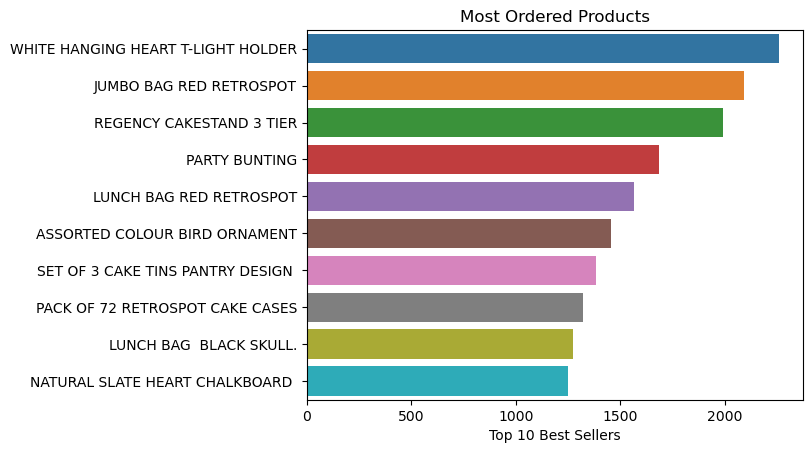

In [184]:
# Plotting the top sellers
top_sellers_df = top_sellers.toPandas()
sns.barplot(data=top_sellers_df, x="count", y="Description")
plt.xlabel("Top 10 Best Sellers")
plt.ylabel("")
plt.title("Most Ordered Products")
plt.show()


In [185]:
# How many items does each customer buy?
average_items_per_order = df.groupBy("InvoiceNo").avg("Quantity")
average_items_per_order.show(5)

+---------+-----------------+
|InvoiceNo|    avg(Quantity)|
+---------+-----------------+
| 536623.0|           13.875|
| 537849.0|             60.0|
| 538279.0|67.42857142857143|
| 539334.0|              1.0|
| 540642.0|             12.7|
+---------+-----------------+
only showing top 5 rows



In [186]:
# What is the average value per order?
df.withColumn("Value", df["UnitPrice"] * df["Quantity"]).groupBy("InvoiceNo").avg("Value").show(5)

+---------+------------------+
|InvoiceNo|        avg(Value)|
+---------+------------------+
| 536623.0| 16.00791666666667|
| 537849.0|              75.0|
| 538279.0| 98.02285714285713|
| 539334.0|2.5949999999999998|
| 540642.0|24.761200000000002|
+---------+------------------+
only showing top 5 rows



In [187]:
# Which countries do they sell their goods to?
country_sales = df.groupBy("Country").sum("Quantity")
country_sales = country_sales.orderBy(country_sales["sum(Quantity)"].desc())
country_sales.show(5)

+--------------+-------------+
|       Country|sum(Quantity)|
+--------------+-------------+
|United Kingdom|      4692510|
|   Netherlands|       200937|
|          EIRE|       147252|
|       Germany|       119119|
|        France|       111918|
+--------------+-------------+
only showing top 5 rows



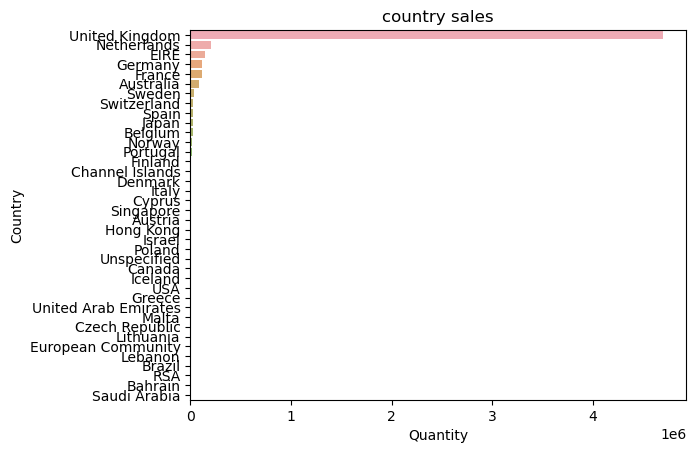

In [188]:
country_sales_df = country_sales.toPandas()
sns.barplot(data=country_sales_df, x="sum(Quantity)", y="Country", alpha=0.8)
plt.xlabel("Quantity")
plt.ylabel("Country")
plt.title("country sales")
plt.show()